In [1]:
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import time
import copy
from collections import Counter

class PCamDataset(Dataset):
    def __init__(self, h5_x_path, h5_y_path, transform=None):
        self.x_h5 = h5py.File(h5_x_path, 'r')
        self.y_h5 = h5py.File(h5_y_path, 'r')
        self.transform = transform
        self.length = len(self.y_h5['y'])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = self.x_h5['x'][idx]  # shape: (96, 96, 3), dtype: uint8
        label = self.y_h5['y'][idx].item()


        # numpy → PIL → transform
        image = image.astype(np.uint8)
        image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)

        return image, label

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの設定 (あなたのコードをそのまま使用)
train_dataset = PCamDataset('camelyonpatch_level_2_split_train_x.h5',
                           'camelyonpatch_level_2_split_train_y.h5',
                           transform=transform_train)

test_dataset = PCamDataset('camelyonpatch_level_2_split_test_x.h5',
                          'camelyonpatch_level_2_split_test_y.h5',
                          transform=transform_test)

val_dataset = PCamDataset('valid_x_uncompressed.h5', 'valid_y_uncompressed.h5', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [2]:
# クラス不均衡に対処するためのWeightedRandomSampler
def get_sampler(dataset):
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

train_sampler = get_sampler(train_dataset)
val_sampler = get_sampler(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, sampler=val_sampler, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

# Focal Lossの実装 (クラス不均衡対策)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# モデルの定義と初期化
def initialize_model():
    model = models.resnet50(pretrained=True)
    
    # 入力チャネルが3x96x96なので最初の層を調整
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    # 最終層をバイナリ分類用に変更
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 1)
    )
    
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = initialize_model().to(device)

# 損失関数とオプティマイザ
criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# 学習率スケジューラー
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=30)

# 早期終了のための変数
early_stopping_patience = 5
best_val_accuracy = 0.0
epochs_without_improvement = 0

# 学習と検証の関数
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score
from tqdm import tqdm
import time
import copy
from collections import Counter
import numpy as np

# 訓練と検証の関数を改良
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    global best_val_accuracy, epochs_without_improvement
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # 各エポックの訓練と検証のフェーズ
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []
            all_probs = []
            
            # データをイテレート
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                
                # 勾配をゼロに
                optimizer.zero_grad()
                
                # 順伝播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    probs = torch.sigmoid(outputs)
                    preds = probs > 0.5
                    loss = criterion(outputs, labels)
                    
                    # 訓練フェーズなら逆伝播+最適化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                # 統計
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # メトリクス計算用にデータを保存
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().detach().numpy())
            
            # エポックごとのメトリクス計算
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Recall (感度) をクラスごとに計算
            recall_0 = recall_score(all_labels, all_preds, pos_label=0)
            recall_1 = recall_score(all_labels, all_preds, pos_label=1)
            
            # AUCを計算
            try:
                auc = roc_auc_score(all_labels, all_probs)
            except ValueError:
                auc = 0.5  # 例外が発生した場合のデフォルト値
            
            print(f'{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
            print(f'{phase} Class 0 Recall: {recall_0:.4f} | Class 1 Recall: {recall_1:.4f}')
            print(f'{phase} AUC: {auc:.4f}')
            print()
            
            # 検証フェーズでモデルを保存
            if phase == 'val':
                if epoch_acc > best_val_accuracy:
                    best_val_accuracy = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_without_improvement = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    epochs_without_improvement += 1
                    print(f'No improvement for {epochs_without_improvement} epochs')
                    if epochs_without_improvement >= early_stopping_patience:
                        print('Early stopping!')
                        model.load_state_dict(best_model_wts)
                        return model
    
    model.load_state_dict(best_model_wts)
    return model

# テスト評価関数も同様に改良
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            preds = preds.squeeze().long()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # 精度計算
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    recall_0 = recall_score(all_labels, all_preds, pos_label=0)
    recall_1 = recall_score(all_labels, all_preds, pos_label=1)
    auc = roc_auc_score(all_labels, all_probs)
    
    print(f'Overall Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Class 0 Recall: {recall_0 * 100:.2f}% | False Alarms: {cm[0,1]}')
    print(f'Class 1 Recall: {recall_1 * 100:.2f}% | False Alarms: {cm[1,0]}')
    print(f'AUC: {auc:.4f}')
    
    return accuracy, cm, recall_0, recall_1, auc

# モデルを訓練
model = train_model(model, criterion, optimizer, scheduler, num_epochs=30)

# モデル評価
test_accuracy, confusion_matrix, recall_0, recall_1, auc = evaluate_model(model, test_loader)

/home/gotou/miniconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gotou/miniconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------


100%|██████████| 2048/2048 [03:51<00:00,  8.86it/s]


train Loss: 0.0831 | Acc: 0.8090
train Class 0 Recall: 0.8037 | Class 1 Recall: 0.8143
train AUC: 0.8893



100%|██████████| 256/256 [00:09<00:00, 28.32it/s]


val Loss: 0.0842 | Acc: 0.7839
val Class 0 Recall: 0.8674 | Class 1 Recall: 0.7011
val AUC: 0.8941

Epoch 1/29
----------


100%|██████████| 2048/2048 [03:55<00:00,  8.68it/s]


train Loss: 0.0627 | Acc: 0.8673
train Class 0 Recall: 0.8707 | Class 1 Recall: 0.8640
train AUC: 0.9398



100%|██████████| 256/256 [00:08<00:00, 28.52it/s]


val Loss: 0.0752 | Acc: 0.8178
val Class 0 Recall: 0.9214 | Class 1 Recall: 0.7168
val AUC: 0.9250

Epoch 2/29
----------


100%|██████████| 2048/2048 [03:56<00:00,  8.68it/s]


train Loss: 0.0539 | Acc: 0.8899
train Class 0 Recall: 0.8976 | Class 1 Recall: 0.8822
train AUC: 0.9556



100%|██████████| 256/256 [00:09<00:00, 28.26it/s]


val Loss: 0.0915 | Acc: 0.8145
val Class 0 Recall: 0.9566 | Class 1 Recall: 0.6722
val AUC: 0.9226

No improvement for 1 epochs
Epoch 3/29
----------


100%|██████████| 2048/2048 [03:55<00:00,  8.68it/s]


train Loss: 0.0501 | Acc: 0.8985
train Class 0 Recall: 0.9075 | Class 1 Recall: 0.8897
train AUC: 0.9614



100%|██████████| 256/256 [00:09<00:00, 28.24it/s]


val Loss: 0.0704 | Acc: 0.8487
val Class 0 Recall: 0.9201 | Class 1 Recall: 0.7771
val AUC: 0.9341

Epoch 4/29
----------


100%|██████████| 2048/2048 [03:55<00:00,  8.68it/s]


train Loss: 0.0483 | Acc: 0.9035
train Class 0 Recall: 0.9142 | Class 1 Recall: 0.8928
train AUC: 0.9640



100%|██████████| 256/256 [00:09<00:00, 28.37it/s]


val Loss: 0.0626 | Acc: 0.8784
val Class 0 Recall: 0.8945 | Class 1 Recall: 0.8625
val AUC: 0.9500

Epoch 5/29
----------


100%|██████████| 2048/2048 [03:56<00:00,  8.67it/s]


train Loss: 0.0479 | Acc: 0.9050
train Class 0 Recall: 0.9174 | Class 1 Recall: 0.8926
train AUC: 0.9646



100%|██████████| 256/256 [00:09<00:00, 28.26it/s]


val Loss: 0.0631 | Acc: 0.8597
val Class 0 Recall: 0.9009 | Class 1 Recall: 0.8181
val AUC: 0.9443

No improvement for 1 epochs
Epoch 6/29
----------


100%|██████████| 2048/2048 [03:55<00:00,  8.69it/s]


train Loss: 0.0475 | Acc: 0.9062
train Class 0 Recall: 0.9180 | Class 1 Recall: 0.8945
train AUC: 0.9654



100%|██████████| 256/256 [00:09<00:00, 28.41it/s]


val Loss: 0.0610 | Acc: 0.8725
val Class 0 Recall: 0.8974 | Class 1 Recall: 0.8477
val AUC: 0.9448

No improvement for 2 epochs
Epoch 7/29
----------


100%|██████████| 2048/2048 [03:55<00:00,  8.68it/s]


train Loss: 0.0456 | Acc: 0.9112
train Class 0 Recall: 0.9220 | Class 1 Recall: 0.9004
train AUC: 0.9680



100%|██████████| 256/256 [00:08<00:00, 28.46it/s]


val Loss: 0.0628 | Acc: 0.8666
val Class 0 Recall: 0.8753 | Class 1 Recall: 0.8579
val AUC: 0.9410

No improvement for 3 epochs
Epoch 8/29
----------


100%|██████████| 2048/2048 [03:55<00:00,  8.69it/s]


train Loss: 0.0428 | Acc: 0.9176
train Class 0 Recall: 0.9277 | Class 1 Recall: 0.9075
train AUC: 0.9719



100%|██████████| 256/256 [00:09<00:00, 28.25it/s]


val Loss: 0.0683 | Acc: 0.8568
val Class 0 Recall: 0.9477 | Class 1 Recall: 0.7663
val AUC: 0.9437

No improvement for 4 epochs
Epoch 9/29
----------


100%|██████████| 2048/2048 [03:55<00:00,  8.69it/s]


train Loss: 0.0397 | Acc: 0.9234
train Class 0 Recall: 0.9333 | Class 1 Recall: 0.9134
train AUC: 0.9756



100%|██████████| 256/256 [00:08<00:00, 28.56it/s]


val Loss: 0.0802 | Acc: 0.8445
val Class 0 Recall: 0.9329 | Class 1 Recall: 0.7559
val AUC: 0.9385

No improvement for 5 epochs
Early stopping!


100%|██████████| 256/256 [00:08<00:00, 28.77it/s]


Overall Test Accuracy: 85.10%
Class 0 Recall: 90.57% | False Alarms: 1546
Class 1 Recall: 79.62% | False Alarms: 3337
AUC: 0.9375


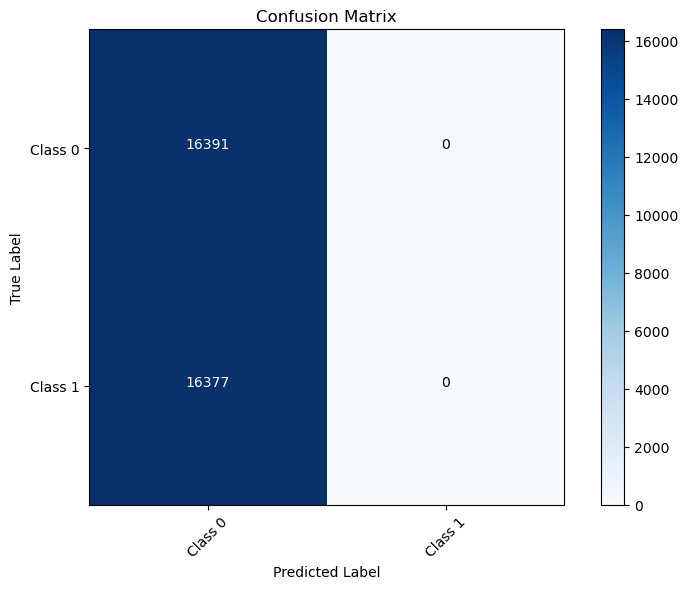

Overall Test Accuracy: 50.02%
Class 0 Accuracy: 100.00%
Class 0 False Alarms: 16377
Class 1 Accuracy: 0.00%
Class 1 False Alarms: 0


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. 予測値と正解ラベルの収集
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 2. 混同行列を手動で計算する関数
def plot_confusion_matrix(true_labels, pred_labels, classes):
    """
    手動で混同行列を計算し可視化
    :param true_labels: 正解ラベルのリスト
    :param pred_labels: 予測ラベルのリスト
    :param classes: クラス名のリスト（例: ['Normal', 'Tumor']）
    """
    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for t, p in zip(true_labels, pred_labels):
        cm[t, p] += 1
    
    # 可視化
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # セル内に数値を表示
    thresh = cm.max() / 2.
    for i in range(n_classes):
        for j in range(n_classes):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()
    
    return cm

# 3. 混同行列の表示
classes = ['Class 0', 'Class 1']  # 実際のクラス名に変更
cm = plot_confusion_matrix(all_labels, all_preds, classes)

# 4. 精度レポート
test_acc = 100 * np.sum(np.diag(cm)) / np.sum(cm)
print(f"Overall Test Accuracy: {test_acc:.2f}%")

for i, class_name in enumerate(classes):
    accuracy = 100 * cm[i,i] / np.sum(cm[i])
    print(f"{class_name} Accuracy: {accuracy:.2f}%")
    print(f"{class_name} False Alarms: {np.sum(cm[:,i]) - cm[i,i]}")